In [253]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, matthews_corrcoef, confusion_matrix

model_name = 'ViT-L32'

y_true = np.load(f'{model_name}/y_true.npy')
y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
fpr_sl, tpr_sl, thr_sl = roc_curve(y_true, y_pred_sl)
fpr_mpl, tpr_mpl, thr_mpl = roc_curve(y_true, y_pred_mpl)
print(y_true)
print(y_pred_sl)
print(y_pred_mpl)

[0 0 0 ... 1 1 1]
[1.0117650e-01 7.6581724e-05 1.8788984e-01 ... 9.3722457e-01 1.8579990e-01
 6.6389990e-01]
[0.07286415 0.00188307 0.3755199  ... 0.3580216  0.16825227 0.42803803]


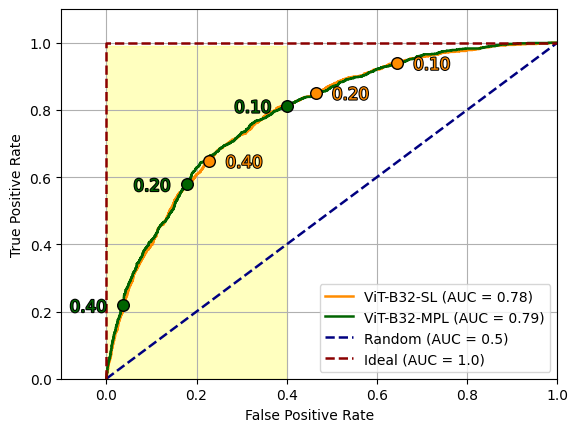

In [254]:
from matplotlib import pyplot as plt
from matplotlib import patheffects

# Plot ROC curve of ViT-B32
model_name = 'ViT-B32'
y_true = np.load(f'{model_name}/y_true.npy')
y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
fpr_sl, tpr_sl, thr_sl = roc_curve(y_true, y_pred_sl)
fpr_mpl, tpr_mpl, thr_mpl = roc_curve(y_true, y_pred_mpl)
plt.figure()
lw = 1.8
plt.plot(fpr_sl, tpr_sl, color='darkorange',
         lw=lw, label=f'{model_name}-SL' + ' (AUC = %0.2f)' % auc(fpr_sl, tpr_sl))
plt.plot(fpr_mpl, tpr_mpl, color='darkgreen',
        lw=lw, label=f'{model_name}-MPL' + ' (AUC = %0.2f)' % auc(fpr_mpl, tpr_mpl))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random (AUC = 0.5)')
plt.plot([0, 0, 1], [0, 1, 1], color='darkred', lw=lw, linestyle='--', label='Ideal (AUC = 1.0)')

for threshold in [0.1, 0.2, 0.4]:
    # Find the closest threshold index in SL curve
        idx_sl = np.argmin(np.abs(thr_sl - threshold))
        text = plt.annotate(f'{threshold:.2f}', (fpr_sl[idx_sl], tpr_sl[idx_sl]), 
                     textcoords="offset points", xytext=(25,-5), ha='center', 
                     color='darkorange', fontsize=12)
        text.set_path_effects([patheffects.withStroke(linewidth=1.5, foreground='black')])
        plt.scatter(fpr_sl[idx_sl], tpr_sl[idx_sl], color='darkorange',
                    edgecolors='black', s=70, zorder=10)

        # Find the closest threshold index in MPL curve
        idx_mpl = np.argmin(np.abs(thr_mpl - threshold))
        text = plt.annotate(f'{threshold:.2f}', (fpr_mpl[idx_mpl], tpr_mpl[idx_mpl]), 
                     textcoords="offset points", xytext=(-25,-5), ha='center', 
                     color='darkgreen', fontsize=12)
        text.set_path_effects([patheffects.withStroke(linewidth=1.5, foreground='black')])
        plt.scatter(fpr_mpl[idx_mpl], tpr_mpl[idx_mpl], color='darkgreen',
                    edgecolors='black', s=70, zorder=10)

plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.axvspan(0, 0.4, 0.0, 0.9, color='yellow', alpha=0.25)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig(f'{model_name}/roc-auc.png', dpi=800)
plt.show()

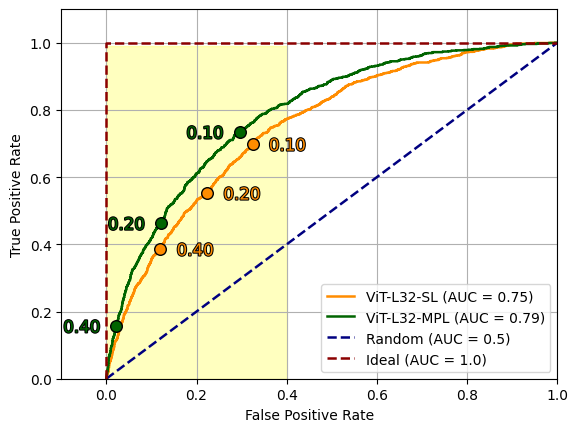

In [255]:
from matplotlib import pyplot as plt
from matplotlib import patheffects

# Plot ROC curve of ViT-L32
model_name = 'ViT-L32'
y_true = np.load(f'{model_name}/y_true.npy')
y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
fpr_sl, tpr_sl, thr_sl = roc_curve(y_true, y_pred_sl)
fpr_mpl, tpr_mpl, thr_mpl = roc_curve(y_true, y_pred_mpl)
plt.figure()
lw = 1.8
plt.plot(fpr_sl, tpr_sl, color='darkorange',
         lw=lw, label=f'{model_name}-SL' + ' (AUC = %0.2f)' % auc(fpr_sl, tpr_sl))
plt.plot(fpr_mpl, tpr_mpl, color='darkgreen',
        lw=lw, label=f'{model_name}-MPL' + ' (AUC = %0.2f)' % auc(fpr_mpl, tpr_mpl))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random (AUC = 0.5)')
plt.plot([0, 0, 1], [0, 1, 1], color='darkred', lw=lw, linestyle='--', label='Ideal (AUC = 1.0)')

for threshold in [0.1, 0.2, 0.4]:
    # Find the closest threshold index in SL curve
        idx_sl = np.argmin(np.abs(thr_sl - threshold))
        text = plt.annotate(f'{threshold:.2f}', (fpr_sl[idx_sl], tpr_sl[idx_sl]), 
                     textcoords="offset points", xytext=(25,-5), ha='center', 
                     color='darkorange', fontsize=12)
        text.set_path_effects([patheffects.withStroke(linewidth=1.5, foreground='black')])
        plt.scatter(fpr_sl[idx_sl], tpr_sl[idx_sl], color='darkorange',
                    edgecolors='black', s=70, zorder=10)

        # Find the closest threshold index in MPL curve
        idx_mpl = np.argmin(np.abs(thr_mpl - threshold))
        text = plt.annotate(f'{threshold:.2f}', (fpr_mpl[idx_mpl], tpr_mpl[idx_mpl]), 
                     textcoords="offset points", xytext=(-25,-5), ha='center', 
                     color='darkgreen', fontsize=12)
        text.set_path_effects([patheffects.withStroke(linewidth=1.5, foreground='black')])
        plt.scatter(fpr_mpl[idx_mpl], tpr_mpl[idx_mpl], color='darkgreen',
                    edgecolors='black', s=70, zorder=10)

plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.axvspan(0, 0.4, 0.0, 0.9, color='yellow', alpha=0.25)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig(f'{model_name}/roc-auc.png', dpi=800)
plt.show()

In [256]:
import numpy as np

def find_threshold_for_fpr(fpr_sl, thr_sl, fpr_mpl, thr_mpl, target_fpr):
    """
    Find the closest threshold for a given FPR for both models.

    Parameters:
    - fpr_sl: Array of FPR values for the SL model.
    - thr_sl: Array of threshold values for the SL model.
    - fpr_mpl: Array of FPR values for the MPL model.
    - thr_mpl: Array of threshold values for the MPL model.
    - target_fpr: The target FPR value.

    Returns:
    A tuple containing the closest thresholds for the SL and MPL models.
    """
    # Find the index of the closest FPR to the target for each model
    idx_sl = np.argmin(np.abs(fpr_sl - target_fpr))
    idx_mpl = np.argmin(np.abs(fpr_mpl - target_fpr))

    # Retrieve the corresponding thresholds
    threshold_sl = thr_sl[idx_sl]
    threshold_mpl = thr_mpl[idx_mpl]

    return threshold_sl, threshold_mpl

# Example usage
target_fpr = 0.2  # Define your target FPR here
# You need to have fpr_sl, thr_sl, fpr_mpl, thr_mpl defined as per your ROC calculation
threshold_sl, threshold_mpl = find_threshold_for_fpr(fpr_sl, thr_sl, fpr_mpl, thr_mpl, target_fpr)
print(f"SL model threshold: {threshold_sl}, MPL model threshold: {threshold_mpl}")

SL model threshold: 0.233506977558136, MPL model threshold: 0.14190265536308289


In [257]:
y_pred_sl_bin = (y_pred_sl > threshold_sl).astype(int)
y_pred_mpl_bin = (y_pred_mpl > threshold_mpl).astype(int)
matt_coeff_sl = matthews_corrcoef(y_true, y_pred_sl_bin)
matt_coeff_mpl = matthews_corrcoef(y_true, y_pred_mpl_bin)
print(f"Matthews correlation coefficient for SL model: {matt_coeff_sl}")
print(f"Matthews correlation coefficient for MPL model: {matt_coeff_mpl}")

Matthews correlation coefficient for SL model: 0.24319136863601173
Matthews correlation coefficient for MPL model: 0.2992054777607813


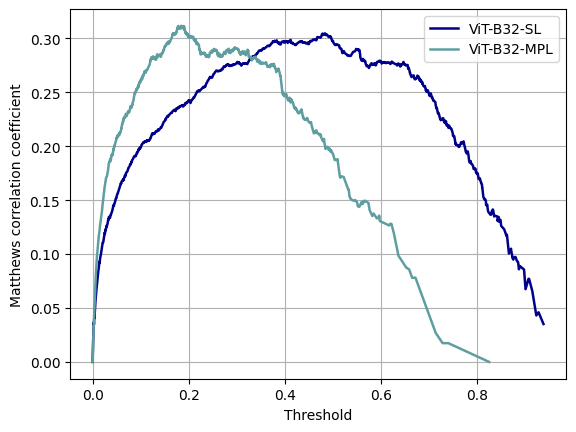

In [258]:
# Plot MCC for ViT-B32

import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_mcc(y_true, y_pred_probs, thresholds):
    """
    Calculate Matthews correlation coefficient for different thresholds.

    Parameters:
    - y_true: Array of true binary labels.
    - y_pred_probs: Array of predicted probabilities for the positive class.
    - thresholds: List of threshold values to evaluate.

    Returns:
    A dictionary mapping each threshold to its MCC.
    """
    mcc_scores = {}
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate MCC
        denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = 0 if denominator == 0 else (tp * tn - fp * fn) / denominator
        
        mcc_scores[threshold] = mcc
    
    return mcc_scores

model_name = 'ViT-B32'
y_true = np.load(f'{model_name}/y_true.npy')
y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
mcc_scores_sl = calculate_mcc(y_true, y_pred_sl, thr_sl)
mcc_scores_mpl = calculate_mcc(y_true, y_pred_mpl, thr_mpl)
plt.plot(figsize=(10, 6))
lw = 1.8
plt.plot(thr_sl, list(mcc_scores_sl.values()), label=f'{model_name}-SL', color = 'darkblue', lw=lw)
plt.plot(thr_mpl, list(mcc_scores_mpl.values()), label=f'{model_name}-MPL', color = 'cadetblue', lw=lw)
plt.xlabel('Threshold')
plt.ylabel('Matthews correlation coefficient')
plt.legend()
plt.grid()
plt.savefig(f'{model_name}/mcc.png', dpi=800)
plt.show()


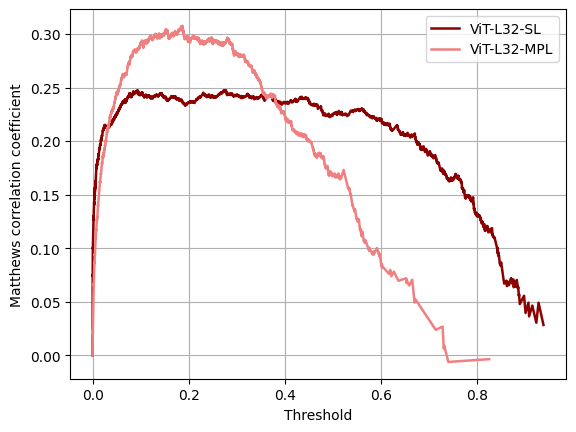

In [259]:
# Plot MCC for ViT-L32

import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_mcc(y_true, y_pred_probs, thresholds):
    """
    Calculate Matthews correlation coefficient for different thresholds.

    Parameters:
    - y_true: Array of true binary labels.
    - y_pred_probs: Array of predicted probabilities for the positive class.
    - thresholds: List of threshold values to evaluate.

    Returns:
    A dictionary mapping each threshold to its MCC.
    """
    mcc_scores = {}
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate MCC
        denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = 0 if denominator == 0 else (tp * tn - fp * fn) / denominator
        
        mcc_scores[threshold] = mcc
    
    return mcc_scores

model_name = 'ViT-L32'
y_true = np.load(f'{model_name}/y_true.npy')
y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
mcc_scores_sl = calculate_mcc(y_true, y_pred_sl, thr_sl)
mcc_scores_mpl = calculate_mcc(y_true, y_pred_mpl, thr_mpl)
plt.plot()
lw = 1.8
plt.plot(thr_sl, list(mcc_scores_sl.values()), label=f'{model_name}-SL', color = 'darkred', lw=lw)
plt.plot(thr_mpl, list(mcc_scores_mpl.values()), label=f'{model_name}-MPL', color = 'lightcoral', lw=lw)
plt.xlabel('Threshold')
plt.ylabel('Matthews correlation coefficient')
plt.legend()
plt.grid()
plt.savefig(f'{model_name}/mcc.png', dpi=800)
plt.show()


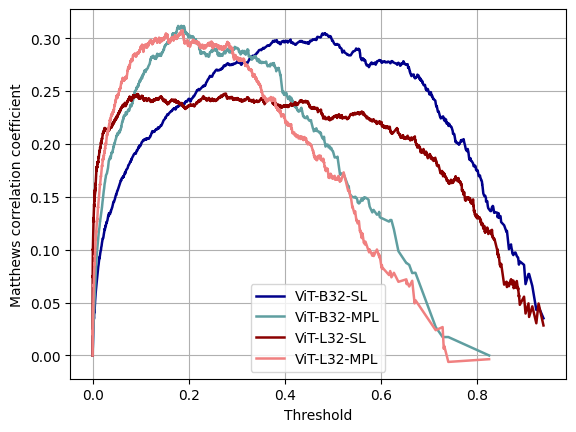

In [266]:
# Plot all MCCs
model_names = ['ViT-B32', 'ViT-L32']
colors_sl = ['darkblue', 'darkred']
colors_mpl = ['cadetblue', 'lightcoral']
plt.plot()
lw = 1.8
for i, model_name in enumerate(model_names):
    y_true = np.load(f'{model_name}/y_true.npy')
    y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
    y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
    mcc_scores_sl = calculate_mcc(y_true, y_pred_sl, thr_sl)
    mcc_scores_mpl = calculate_mcc(y_true, y_pred_mpl, thr_mpl)
    plt.plot(thr_sl, list(mcc_scores_sl.values()), label=f'{model_name}-SL', color = colors_sl[i], lw=lw)
    plt.plot(thr_mpl, list(mcc_scores_mpl.values()), label=f'{model_name}-MPL', color = colors_mpl[i], lw=lw)
plt.xlabel('Threshold')
plt.ylabel('Matthews correlation coefficient')
plt.legend()
plt.grid()
plt.savefig(f'mcc_comp.png', dpi=800)
plt.show()

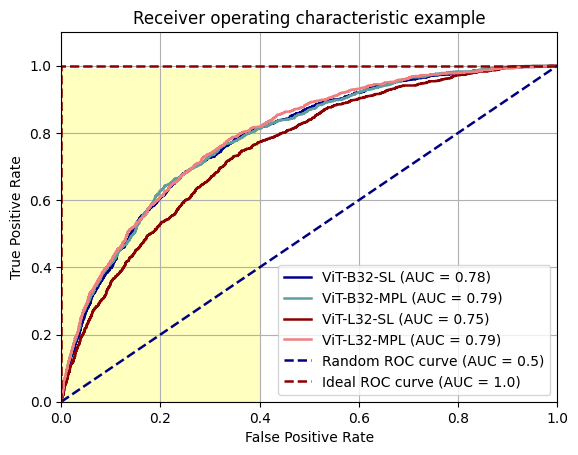

In [267]:
# Plot ROC curves of all models
model_names = ['ViT-B32', 'ViT-L32']
colors_sl = ['darkblue', 'darkred']
colors_mpl = ['cadetblue', 'lightcoral']
lw = 1.8
plt.figure()
for i, model_name in enumerate(model_names):
    y_true = np.load(f'{model_name}/y_true.npy')
    y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
    y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
    fpr_sl, tpr_sl, thr_sl = roc_curve(y_true, y_pred_sl)
    fpr_mpl, tpr_mpl, thr_mpl = roc_curve(y_true, y_pred_mpl)
    plt.plot(fpr_sl, tpr_sl, color=colors_sl[i],
            lw=lw, label=f'{model_name}-SL (AUC = %0.2f)' % auc(fpr_sl, tpr_sl))
    plt.plot(fpr_mpl, tpr_mpl, color=colors_mpl[i],
            lw=lw, label=f'{model_name}-MPL (AUC = %0.2f)' % auc(fpr_mpl, tpr_mpl))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random ROC curve (AUC = 0.5)')
plt.plot([0, 0, 1], [0, 1, 1], color='darkred', lw=lw, linestyle='--', label='Ideal ROC curve (AUC = 1.0)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.axvspan(0, 0.4, 0.0, 0.9, color='yellow', alpha=0.25)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('roc-auc_comp.png', dpi=800)
plt.show()

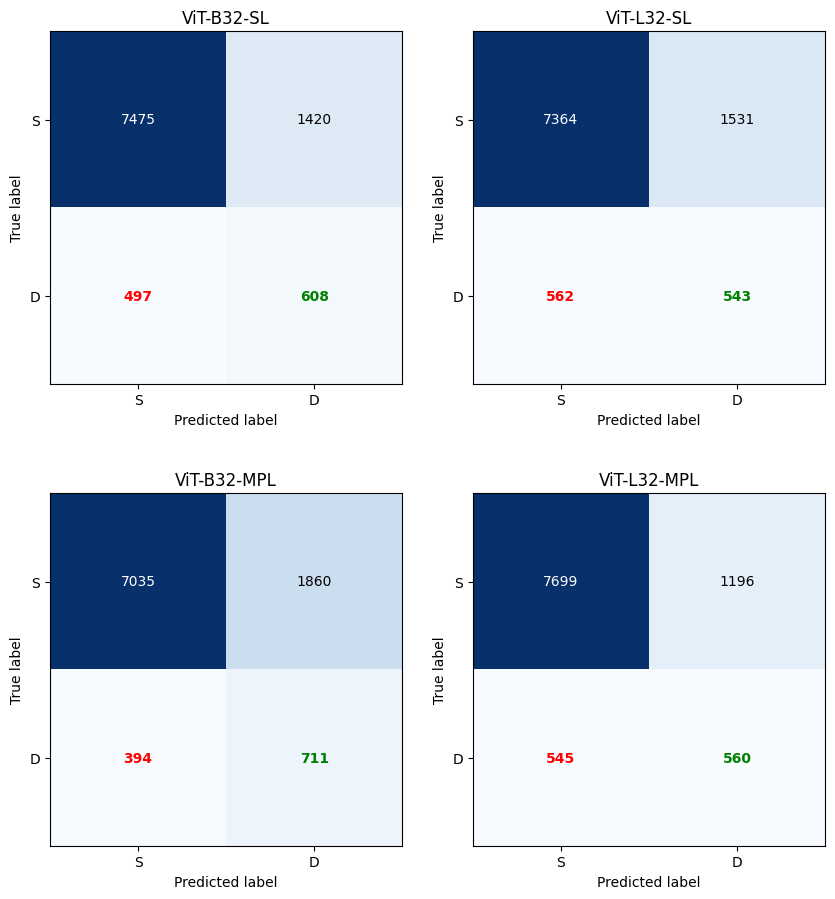

In [262]:
# Plot all confusion matrices
model_names = ['ViT-B32', 'ViT-L32']
lw = 1.8
plt.figure(figsize=(10, 11))
for i, model_name in enumerate(model_names):
    y_true = np.load(f'{model_name}/y_true.npy')
    y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
    y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
    # Find best threshold for SL maximizing MCC
    mcc_scores_sl = calculate_mcc(y_true, y_pred_sl, thr_sl)
    best_thr_sl = max(mcc_scores_sl, key=mcc_scores_sl.get)
    y_pred_sl_bin = (y_pred_sl > best_thr_sl).astype(int)
    # Find best threshold for MPL maximizing MCC
    mcc_scores_mpl = calculate_mcc(y_true, y_pred_mpl, thr_mpl)
    best_thr_mpl = max(mcc_scores_mpl, key=mcc_scores_mpl.get)
    y_pred_mpl_bin = (y_pred_mpl > best_thr_mpl).astype(int)
    conf_matrix_sl = confusion_matrix(y_true, y_pred_sl_bin)
    conf_matrix_mpl = confusion_matrix(y_true, y_pred_mpl_bin)
    plt.subplot(2, 2, i+1)
    plt.imshow(conf_matrix_sl, cmap='Blues', interpolation='nearest')
    # plt.colorbar()
    plt.title(f'{model_name}-SL')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1], ['S', 'D'])
    plt.yticks([0, 1], ['S', 'D'])
    plt.text(0, 0, conf_matrix_sl[0, 0], ha='center', va='center', color='white')
    plt.text(0, 1, conf_matrix_sl[1, 0], ha='center', va='center', color='red', fontweight='bold')
    plt.text(1, 0, conf_matrix_sl[0, 1], ha='center', va='center', color='black')
    plt.text(1, 1, conf_matrix_sl[1, 1], ha='center', va='center', color='green', fontweight='bold')
    
    plt.subplot(2, 2, i+3)
    plt.imshow(conf_matrix_mpl, cmap='Blues', interpolation='nearest')
    # plt.colorbar()
    plt.title(f'{model_name}-MPL')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1], ['S', 'D'])
    plt.yticks([0, 1], ['S', 'D'])
    plt.text(0, 0, conf_matrix_mpl[0, 0], ha='center', va='center', color='white')
    plt.text(0, 1, conf_matrix_mpl[1, 0], ha='center', va='center', color='red', fontweight='bold')
    plt.text(1, 0, conf_matrix_mpl[0, 1], ha='center', va='center', color='black')
    plt.text(1, 1, conf_matrix_mpl[1, 1], ha='center', va='center', color='green', fontweight='bold')

plt.savefig('confusion-matrix_comp.png', dpi=800)
plt.show()


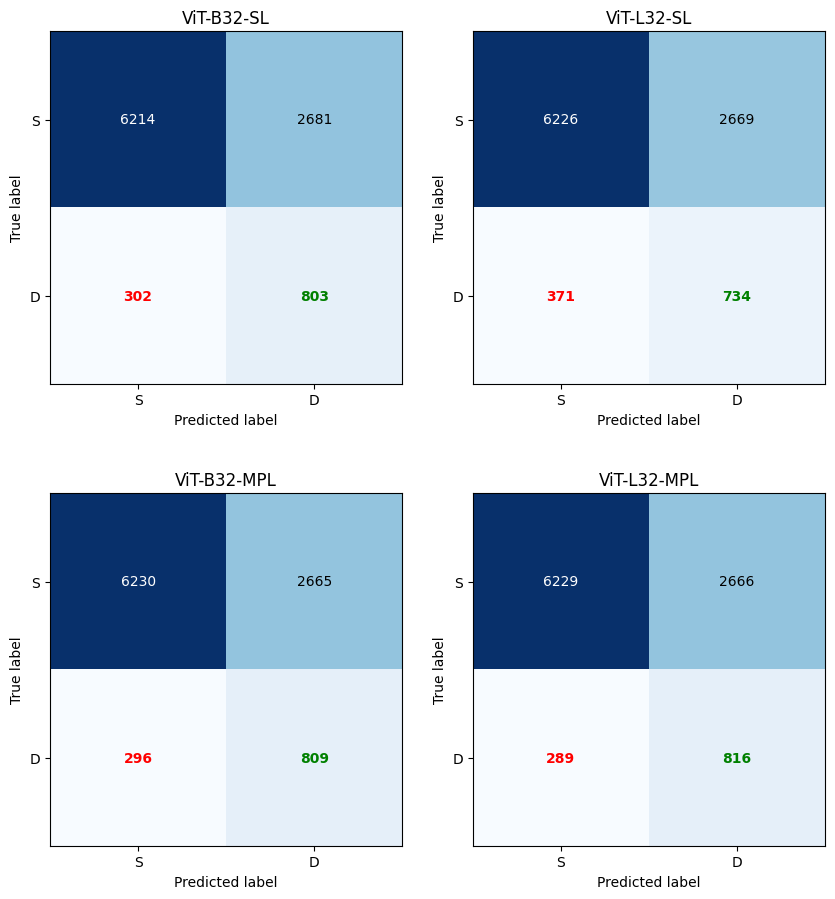

In [263]:
# Plot all confusion matrices with specific FPR
model_names = ['ViT-B32', 'ViT-L32']
target_fpr = 0.3
lw = 1.8
plt.figure(figsize=(10, 11))
for i, model_name in enumerate(model_names):
    y_true = np.load(f'{model_name}/y_true.npy')
    y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
    y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
    # Find best threshold for SL maximizing MCC
    fpr_sl, tpr_sl, thr_sl = roc_curve(y_true, y_pred_sl)
    fpr_mpl, tpr_mpl, thr_mpl = roc_curve(y_true, y_pred_mpl)
    threshold_sl, threshold_mpl = find_threshold_for_fpr(fpr_sl, thr_sl, fpr_mpl, thr_mpl, target_fpr)
    y_pred_sl_bin = (y_pred_sl > threshold_sl).astype(int)
    y_pred_mpl_bin = (y_pred_mpl > threshold_mpl).astype(int)
    conf_matrix_sl = confusion_matrix(y_true, y_pred_sl_bin)
    conf_matrix_mpl = confusion_matrix(y_true, y_pred_mpl_bin)
    plt.subplot(2, 2, i+1)
    plt.imshow(conf_matrix_sl, cmap='Blues', interpolation='nearest')
    # plt.colorbar()
    plt.title(f'{model_name}-SL')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1], ['S', 'D'])
    plt.yticks([0, 1], ['S', 'D'])
    plt.text(0, 0, conf_matrix_sl[0, 0], ha='center', va='center', color='white')
    plt.text(0, 1, conf_matrix_sl[1, 0], ha='center', va='center', color='red', fontweight='bold')
    plt.text(1, 0, conf_matrix_sl[0, 1], ha='center', va='center', color='black')
    plt.text(1, 1, conf_matrix_sl[1, 1], ha='center', va='center', color='green', fontweight='bold')
    
    plt.subplot(2, 2, i+3)
    plt.imshow(conf_matrix_mpl, cmap='Blues', interpolation='nearest')
    # plt.colorbar()
    plt.title(f'{model_name}-MPL')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1], ['S', 'D'])
    plt.yticks([0, 1], ['S', 'D'])
    plt.text(0, 0, conf_matrix_mpl[0, 0], ha='center', va='center', color='white')
    plt.text(0, 1, conf_matrix_mpl[1, 0], ha='center', va='center', color='red', fontweight='bold')
    plt.text(1, 0, conf_matrix_mpl[0, 1], ha='center', va='center', color='black')
    plt.text(1, 1, conf_matrix_mpl[1, 1], ha='center', va='center', color='green', fontweight='bold')

plt.savefig('confusion-matrix_comp_fpr.png', dpi=800)
plt.show()


{'ViT-B32': 0.25504574, 'ViT-L32': 0.07719} {'ViT-B32': 0.12502216, 'ViT-L32': 0.084484346}


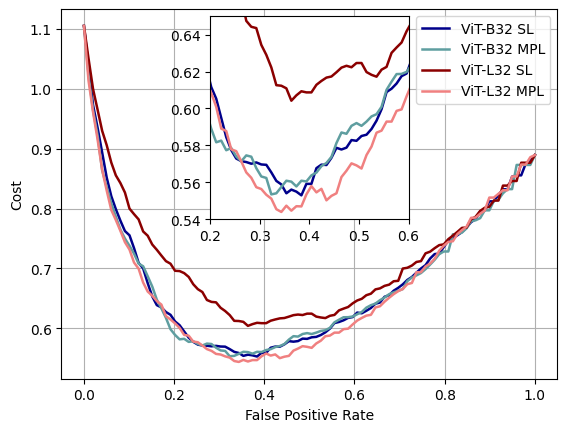

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import roc_curve, confusion_matrix

def cost_fn(conf_matrix, w):
    """
    Calculate the cost function based on the confusion matrix.

    Parameters:
    - conf_matrix: 2x2 confusion matrix.
    - w: Cost weights matrix.

    Returns:
    The cost value.
    """
    return (np.sum(conf_matrix * w) / np.sum(conf_matrix))

def find_threshold_for_fpr(fpr, thresholds, target_fpr):
    """
    Find the threshold for a given target FPR.

    Parameters:
    - fpr: False positive rates.
    - thresholds: Corresponding thresholds.
    - target_fpr: Target false positive rate.

    Returns:
    The threshold corresponding to the target FPR.
    """
    idx = np.argmin(np.abs(fpr - target_fpr))
    return thresholds[idx]

model_names = ['ViT-B32', 'ViT-L32']
colors_sl = ['darkblue', 'darkred']
colors_mpl = ['cadetblue', 'lightcoral']
lw = 1.8
costs = {model_name: [] for model_name in model_names}
best_thr_mpl = {model_name: 0.0 for model_name in model_names}
best_thr_sl = {model_name: 0.0 for model_name in model_names}
min_cost_mpl = {model_name: 1e6 for model_name in model_names}
min_cost_sl = {model_name: 1e6 for model_name in model_names}
w = np.array([[0, 1], [10, 0]])  # Define the cost weights
target_fprs = np.linspace(0, 1, 100)  # Define a range of target FPR values

for target_fpr in target_fprs:
    for i, model_name in enumerate(model_names):
        y_true = np.load(f'{model_name}/y_true.npy')
        y_pred_sl = np.load(f'{model_name}/y_preds_sl.npy')
        y_pred_mpl = np.load(f'{model_name}/y_preds_mpl.npy')
        fpr_sl, tpr_sl, thr_sl = roc_curve(y_true, y_pred_sl)
        fpr_mpl, tpr_mpl, thr_mpl = roc_curve(y_true, y_pred_mpl)
        threshold_sl = find_threshold_for_fpr(fpr_sl, thr_sl, target_fpr)
        threshold_mpl = find_threshold_for_fpr(fpr_mpl, thr_mpl, target_fpr)
        y_pred_sl_bin = (y_pred_sl > threshold_sl).astype(int)
        y_pred_mpl_bin = (y_pred_mpl > threshold_mpl).astype(int)
        conf_matrix_sl = confusion_matrix(y_true, y_pred_sl_bin)
        conf_matrix_mpl = confusion_matrix(y_true, y_pred_mpl_bin)
        cost_sl = cost_fn(conf_matrix_sl, w)
        cost_mpl = cost_fn(conf_matrix_mpl, w)
        if cost_sl < min_cost_sl[model_name]:
            min_cost_sl[model_name] = cost_sl
            best_thr_sl[model_name] = threshold_sl
        if cost_mpl < min_cost_mpl[model_name]:
            min_cost_mpl[model_name] = cost_mpl
            best_thr_mpl[model_name] = threshold_mpl
        costs[model_name].append((cost_sl, cost_mpl))

plt.figure()

# Plot costs for each model across different target FPR values
for model_name in model_names:
    cost_sl = [cost[0] for cost in costs[model_name]]
    cost_mpl = [cost[1] for cost in costs[model_name]]
    plt.plot(target_fprs, cost_sl, label=f'{model_name} SL', lw=lw, color=colors_sl[model_names.index(model_name)])
    plt.plot(target_fprs, cost_mpl, label=f'{model_name} MPL', lw=lw, color=colors_mpl[model_names.index(model_name)])

plt.xlabel('False Positive Rate')
plt.ylabel('Cost')
plt.legend()
plt.grid()
# plt.title('Cost Function vs False Positive Rate')
print(best_thr_sl, best_thr_mpl)


# Add zoom lens (inset)
ax = plt.gca()
axins = inset_axes(ax, width="40%", height="55%", loc='upper center')

# Define the zoom range (you can adjust these values)
x1, x2, y1, y2 = 0.2, 0.6, 0.54, 0.65

for model_name in model_names:
    cost_sl = [cost[0] for cost in costs[model_name]]
    cost_mpl = [cost[1] for cost in costs[model_name]]
    axins.plot(target_fprs, cost_sl, label=f'{model_name} SL', lw=lw, color=colors_sl[model_names.index(model_name)])
    axins.plot(target_fprs, cost_mpl, label=f'{model_name} MPL', lw=lw, color=colors_mpl[model_names.index(model_name)])

# Set the limits for the zoom lens
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.grid()
plt.savefig('cost.png', dpi=800)


plt.show()


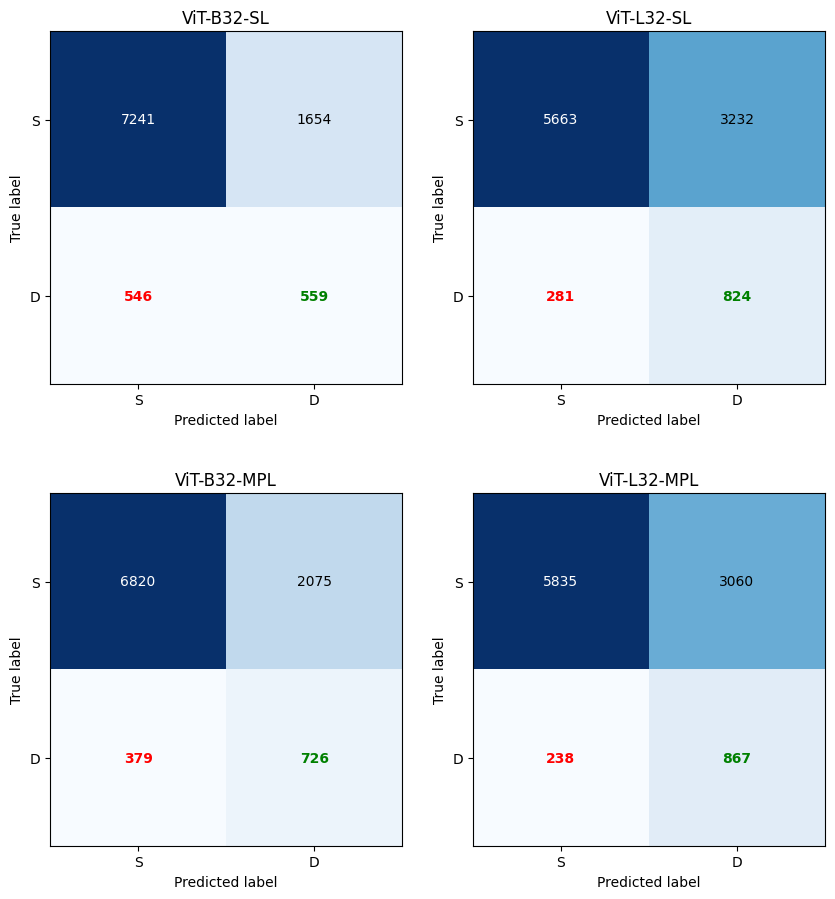

In [269]:
# Plot all confusion matrices with specific thresholds
model_names = ['ViT-B32', 'ViT-L32']
lw = 1.8
plt.figure(figsize=(10, 11))
for i, model_name in enumerate(model_names):
    threshold_sl = best_thr_sl[model_name]
    threshold_mpl = best_thr_mpl[model_name]
    y_pred_sl_bin = (y_pred_sl > threshold_sl).astype(int)
    y_pred_mpl_bin = (y_pred_mpl > threshold_mpl).astype(int)
    conf_matrix_sl = confusion_matrix(y_true, y_pred_sl_bin)
    conf_matrix_mpl = confusion_matrix(y_true, y_pred_mpl_bin)
    plt.subplot(2, 2, i+1)
    plt.imshow(conf_matrix_sl, cmap='Blues', interpolation='nearest')
    # plt.colorbar()
    plt.title(f'{model_name}-SL')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1], ['S', 'D'])
    plt.yticks([0, 1], ['S', 'D'])
    plt.text(0, 0, conf_matrix_sl[0, 0], ha='center', va='center', color='white')
    plt.text(0, 1, conf_matrix_sl[1, 0], ha='center', va='center', color='red', fontweight='bold')
    plt.text(1, 0, conf_matrix_sl[0, 1], ha='center', va='center', color='black')
    plt.text(1, 1, conf_matrix_sl[1, 1], ha='center', va='center', color='green', fontweight='bold')
    
    plt.subplot(2, 2, i+3)
    plt.imshow(conf_matrix_mpl, cmap='Blues', interpolation='nearest')
    # plt.colorbar()
    plt.title(f'{model_name}-MPL')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1], ['S', 'D'])
    plt.yticks([0, 1], ['S', 'D'])
    plt.text(0, 0, conf_matrix_mpl[0, 0], ha='center', va='center', color='white')
    plt.text(0, 1, conf_matrix_mpl[1, 0], ha='center', va='center', color='red', fontweight='bold')
    plt.text(1, 0, conf_matrix_mpl[0, 1], ha='center', va='center', color='black')
    plt.text(1, 1, conf_matrix_mpl[1, 1], ha='center', va='center', color='green', fontweight='bold')

plt.savefig('confusion-matrix_comp_fpr.png', dpi=800)
plt.show()
